In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import ConvGVAEBuilder
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
config,_ = get_config()
setattr(config, 'batch_size', 128)
setattr(config, 'dataset', 'mnist')
setattr(config, 'epochs', 20)
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'z_dim', 4)
setattr(config, 'recon',10)
setattr(config, 'log_dir', '../logs')
# setattr(config, 'xcov', None)
# setattr(config, 'recon', None)
prepare_dirs_and_logger(config)
vars(config)

{'batch_size': 128,
 'data_dir': 'data',
 'dataset': 'mnist',
 'enc_layers': [3000, 2000],
 'epochs': 20,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'model_dir': '../logs/mnist_1008_211431',
 'model_name': 'mnist_1008_211431',
 'optimizer': 'adam',
 'recon': 10,
 'xcov': 10,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 4}

In [3]:
with open(os.path.join(config.model_dir,'params.json'), 'w') as fp:
    json.dump(vars(config), fp)

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
#                          translation=None,
                        )

input_shape:  (3136,)
dataset:  mnist
scale:  2
tx_max:  0.75
rot_max:  None
loading mnist...


  6%|▌         | 3590/60000 [00:00<00:01, 35892.42it/s]

sx_train:  (60000, 3136)
making training data...


 23%|██▎       | 2310/10000 [00:00<00:00, 23089.67it/s]

making testing data...


100%|██████████| 10000/10000 [00:00<00:00, 24216.86it/s]


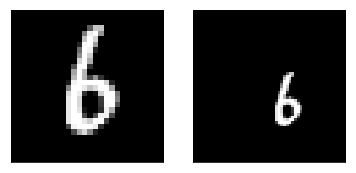

In [5]:
pt,idx = plot_ovt(DL,cmap='gray')

In [6]:
mod_builder = ConvGVAEBuilder(enc_layers=config.enc_layers,z_dim=config.z_dim)

In [7]:
trainer = Trainer(config,DL,mod_builder)

building model...


In [8]:
trainer.compile_model()

In [9]:
trainer.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
y_lat (Dense)                   (None, 10)           20010       dense_2[0][0]                    
__________________________________________________________________________________________________
z_lat (Den

In [ ]:
trainer.go(x=DL.sx_train,y=DL.y_train_oh,validation_split=0.1,verbose=0)

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 14s 255us/step - loss: 972.4062 - acc: 0.7569 - xentropy: 7.3309 - recon_mse: 83.2421 - val_loss: 434.7089 - val_acc: 0.8940 - val_xentropy: 3.2620 - val_recon_mse: 45.4236
Epoch 2/20
54000/54000 [==============================] - 12s 214us/step - loss: 346.0497 - acc: 0.9171 - xentropy: 2.5657 - recon_mse: 42.7902 - val_loss: 357.6259 - val_acc: 0.9172 - val_xentropy: 2.6713 - val_recon_mse: 40.6620
Epoch 3/20
54000/54000 [==============================] - 12s 214us/step - loss: 205.1920 - acc: 0.9512 - xentropy: 1.4734 - recon_mse: 40.0415 - val_loss: 323.9149 - val_acc: 0.9270 - val_xentropy: 2.4134 - val_recon_mse: 38.9242
Epoch 4/20
54000/54000 [==============================] - 12s 214us/step - loss: 145.1985 - acc: 0.9661 - xentropy: 1.0088 - recon_mse: 38.6813 - val_loss: 396.5581 - val_acc: 0.9158 - val_xentropy: 2.9819 - val_recon_mse: 38.0412
Epoch 5/20
54000/54000 [===

In [ ]:
trainer.save_model()

In [ ]:
from keras.models import Model
from keras.layers import Input

In [ ]:
z_encoder = trainer.get_encoder('z_lat')
classifier = trainer.get_encoder('y_lat')
decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
dec_layers = trainer.model.layers[-6:]
print(dec_layers)
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
_gen_x = dec_layers[2](_gen_x)
_gen_x = dec_layers[3](_gen_x)
_gen_x = dec_layers[4](_gen_x)
_gen_x = dec_layers[5](_gen_x)
generator = Model(decoder_inp,_gen_x)

In [ ]:
classifier.summary()

In [ ]:
classifier.compile(loss='mse',optimizer='adam')
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

In [ ]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_class = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [ ]:
z_enc.shape

In [ ]:
_lat_vec = np.concatenate([y_class,z_enc],axis=1)
_lat_vec.shape

In [ ]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

In [ ]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [ ]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_class,generator)

In [ ]:
from src.metrics import var_expl
dxs = DL.dx[1]-14
dys = DL.dy[1]-14
dtheta = DL.dtheta[1]
fve_dx = var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = var_expl(features=z_enc,cond=dys,bins=21)
fve_dt = var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
fve_dy_norm = (dys.var()-fve_dy)/dys.var()
fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dx_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dx')
# plt.ylim(-0.125,0.25)
np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dtheta')
plt.ylim(0.0,0.5)
np.argmax(fve_dth_norm.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[0,3],dxs)

In [ ]:
Z_color_scatter(z_enc,[0,3],dys)

In [ ]:
Z_color_scatter(z_enc,[1,2],dtheta)